In [2]:
import sys
!{sys.executable} -m pip install scikit-learn

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm

from sklearn.model_selection import RandomizedSearchCV


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\edo13\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# DIAGNOSIS OF ALZHEIMERS'S PATIENTS FROM CLINICAL DATA 

In [ ]:
# Import the train.csv data
# WARNING: the test.csv dataset does not contain the diagnosis column

file = "/PATH/alzheimers-disease-risk-prediction-eu-business/train.csv"

data = pd.read_csv(file)

In [4]:
### define sublists of features

demographics = list(data.columns[1:5])
lifestyle = list(data.columns[5:11])
med_history = list(data.columns[11:17])
clinical_measurements = list(data.columns[17:23])
assessments = list(data.columns[23:28])
symptoms = list(data.columns[28:33])
diagnosis = list(data.columns[33:34])

In [6]:
### define a list of features sublists

categories = [demographics,
lifestyle,
med_history,
clinical_measurements, 
assessments,
symptoms,
diagnosis]

In [7]:
# split the features in numerical and categorical ones

numerical = ["Age", 
             "BMI", 
             "AlcoholConsumption", 
             "PhysicalActivity", 
             "DietQuality", 
             "SleepQuality", 
             "SystolicBP", 
             "DiastolicBP", 
             "CholesterolTotal", 
             "CholesterolLDL",
             "CholesterolHDL",
             "CholesterolTriglycerides", 
             "MMSE", 
             "FunctionalAssessment", 
             "ADL"]

categorical = list( set( data.columns.to_list() ) - set( numerical ) - set( ["Diagnosis", "PatientID", "DoctorInCharge"] ) )

## A couple of useful functions...

In [8]:
## function that perform a fit with using a given classifier and return the pipeline, test datasets and the prediction
## the function take as input the dataset, the lists of all categorical and numerical data, a features list and a classifier

def complete_fit( data, categorical, numerical, features_sublist, classifier = RandomForestClassifier()):

    # define the categorical and numerical transformers
    categorical_transformer = Pipeline( [ ("encoder", OneHotEncoder()) ] )
    numerical_transformer = Pipeline( [ ("scaler", StandardScaler()) ] )
    
    # define the lists of categorical and numerical sublists of features
    categorical_subset = list( set(features_sublist) & set(categorical) )
    numerical_subset = list( set(features_sublist) & set(numerical) )

    # define the preprocessor that apply different transformations on numerical and categorical features
    preprocessor = ColumnTransformer( transformers = [ ("num", numerical_transformer, numerical_subset),
                                                       ("cat", categorical_transformer, categorical_subset) ] )
    
    # define the explanatory data and the variable to predict
    x = data[numerical_subset + categorical_subset]
    y = data["Diagnosis"]

    # split the dataset into train/test subdatasets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

    # create pipeline with the given classifier and fit
    pipeline = Pipeline( [ ("preprocessor", preprocessor),
                           ("classifier", classifier) ] )
    
    pipeline.fit(x_train, y_train)

    return pipeline, x_test, y_test, pipeline.predict(x_test)


In [12]:
## function that computes three performance scores (accuracy, precision and recall)

def scores(pipeline, x_test, y_test):
    
    y_pred = pipeline.predict(x_test)

    return {"accuracy": accuracy_score(y_test, y_pred), 
            "precision" : precision_score(y_test, y_pred), 
            "recall" : recall_score(y_test, y_pred)}

## Prediction using all the given features (RANDOM FOREST)

In [ ]:
pipeline, x_test, y_test, y_pred = complete_fit(data, 
                                                categorical, 
                                                numerical, 
                                                list(data.columns[1:33]),
                                                classifier = RandomForestClassifier()
                                                )

In [13]:
scores(pipeline, x_test, y_test)

{'accuracy': 0.9244186046511628,
 'precision': 0.9134615384615384,
 'recall': 0.8482142857142857}

Very good performance with Random Forest, even though the recall is slightly worse than the other scores

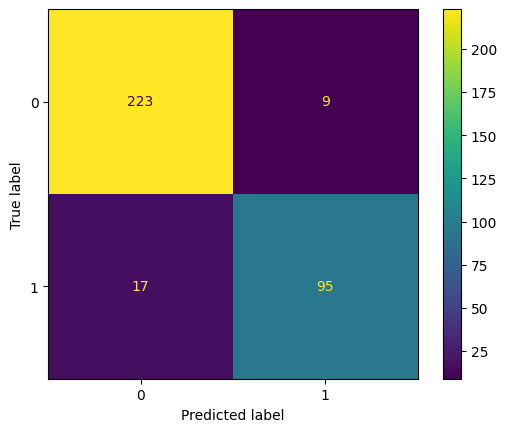

In [14]:
## call confusion matrix and plot 

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()

The confusion matrix agrees with the scores. The false negatives are worse than the false positives (that's way the recall is lower). Now we find the most important features.

In [18]:
## extract features importance from the fit  

model = pipeline.named_steps["classifier"] 
features_imp = model.feature_importances_

preprocessor = pipeline.named_steps["preprocessor"]
features_names = preprocessor.get_feature_names_out()

In [41]:
## sort the features by their importance
## NOTICE: I cut the first 5 characters of each name that are just the type of the feature (num or cat)

features_sorted = sorted( [(features_names[i][5:], features_imp[i]) for i in range(len(features_names)) ], key = lambda x : -x[1] )

In [51]:
features_sorted

[('FunctionalAssessment', 0.1798947149929465),
 ('ADL', 0.15913350681241445),
 ('MMSE', 0.10978769944830821),
 ('MemoryComplaints_1', 0.04961264465641741),
 ('MemoryComplaints_0', 0.041459994333205095),
 ('CholesterolHDL', 0.03134360541295135),
 ('CholesterolTriglycerides', 0.028438780575894877),
 ('PhysicalActivity', 0.028177840365670934),
 ('CholesterolTotal', 0.02641598229115212),
 ('AlcoholConsumption', 0.025860671284970927),
 ('DietQuality', 0.025792435558348543),
 ('SleepQuality', 0.02561121972589361),
 ('BMI', 0.02559891392312258),
 ('BehavioralProblems_1', 0.02525270368625128),
 ('CholesterolLDL', 0.02506738313594053),
 ('BehavioralProblems_0', 0.02340148762545401),
 ('Age', 0.021881912060835403),
 ('DiastolicBP', 0.021760159091414284),
 ('SystolicBP', 0.021418840272901137),
 ('EducationLevel_0', 0.004644433832428427),
 ('Forgetfulness_0', 0.004299578166884677),
 ('Ethnicity_1', 0.004219688085240025),
 ('EducationLevel_3', 0.003821725483306624),
 ('Ethnicity_0', 0.0037449738929

Text(0, 0.5, 'Feature Importance')

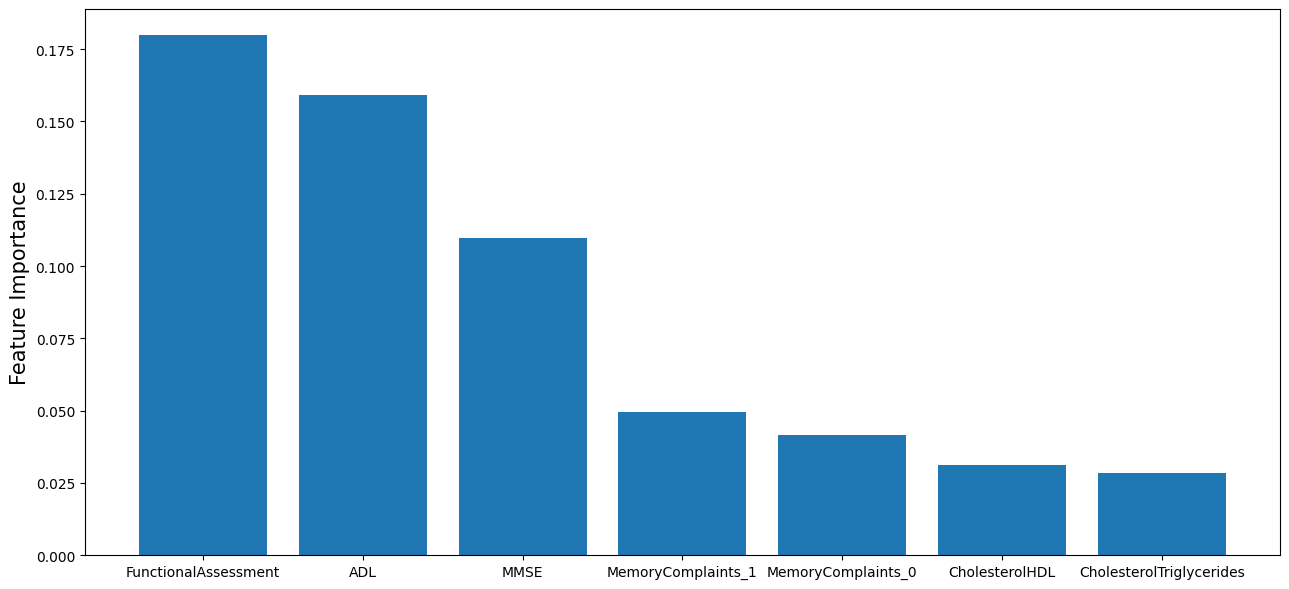

In [50]:
fig, ax = plt.subplots(1, 1, layout = 'tight', figsize = (13, 6))

num_of_shown_feats = 7

ax.bar( [ feat[0] for feat in features_sorted[:num_of_shown_feats] ] , [ feat[1] for feat in features_sorted[:num_of_shown_feats] ], width = 0.8 )

ax.set_ylabel("Feature Importance", fontsize = 15)

The results indicate that some of the assessment features are the most important, followed by measured data like cholesterol and lifestyle features like Physical activity and alcohol consumption.
Can our model classify the patients even without these assessment features?

## Prediction without assessment features (RANDOM FOREST)

In [58]:
features_sublist = list( set(data.columns[1:33]) - set(assessments) ) 

pipeline, x_test, y_test, y_pred = complete_fit(data, 
                                                categorical, 
                                                numerical, 
                                                features_sublist = features_sublist,
                                                classifier = RandomForestClassifier()
                                                )

In [59]:
scores(pipeline, x_test, y_test)

{'accuracy': 0.6337209302325582,
 'precision': 0.38461538461538464,
 'recall': 0.04065040650406504}

Using all the features except the assessment ones the result is way worse...

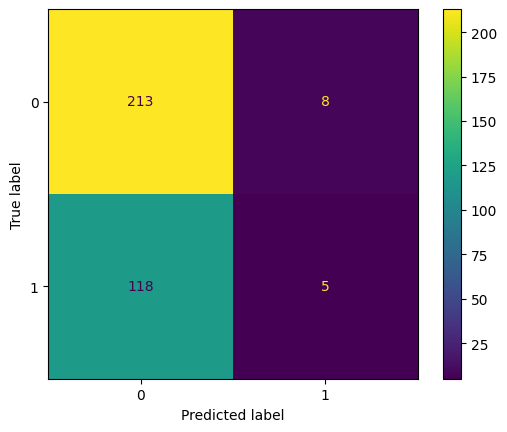

In [60]:
## call confusion matrix and plot 

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()

Without the assessment scores, almost all the patients are classified as healthy. The number of false negatives is extremely high.

In [61]:
## extract features importance from the fit  

model = pipeline.named_steps["classifier"] 
features_imp = model.feature_importances_

preprocessor = pipeline.named_steps["preprocessor"]
features_names = preprocessor.get_feature_names_out()

In [62]:
## sort the features by their importance
## NOTICE: I cut the first 5 characters of each name that are just the type of the feature (num or cat)

features_sorted = sorted( [(features_names[i][5:], features_imp[i]) for i in range(len(features_names)) ], key = lambda x : -x[1] )

In [63]:
features_sorted

[('SleepQuality', 0.06801810419266832),
 ('CholesterolTotal', 0.06785313291061154),
 ('CholesterolHDL', 0.06734715599446543),
 ('DietQuality', 0.06589524503214626),
 ('CholesterolTriglycerides', 0.06527056735449294),
 ('AlcoholConsumption', 0.0634621670036358),
 ('BMI', 0.06342576429743173),
 ('PhysicalActivity', 0.06310310935308479),
 ('CholesterolLDL', 0.06181707188827917),
 ('SystolicBP', 0.06102244804998096),
 ('DiastolicBP', 0.054735159504936924),
 ('Age', 0.05264366115467937),
 ('EducationLevel_1', 0.009205290553045562),
 ('Ethnicity_0', 0.009169632092706525),
 ('Forgetfulness_1', 0.009079373700026103),
 ('EducationLevel_2', 0.008988346105884512),
 ('EducationLevel_0', 0.008856523290101875),
 ('Smoking_0', 0.008715532351664437),
 ('Gender_0', 0.008607254446906116),
 ('Smoking_1', 0.00842513622464547),
 ('FamilyHistoryAlzheimers_1', 0.008270083691764562),
 ('Ethnicity_1', 0.008239164831187945),
 ('Gender_1', 0.008234712083964382),
 ('Depression_0', 0.007911072190514174),
 ('Forget

Text(0, 0.5, 'Feature Importance')

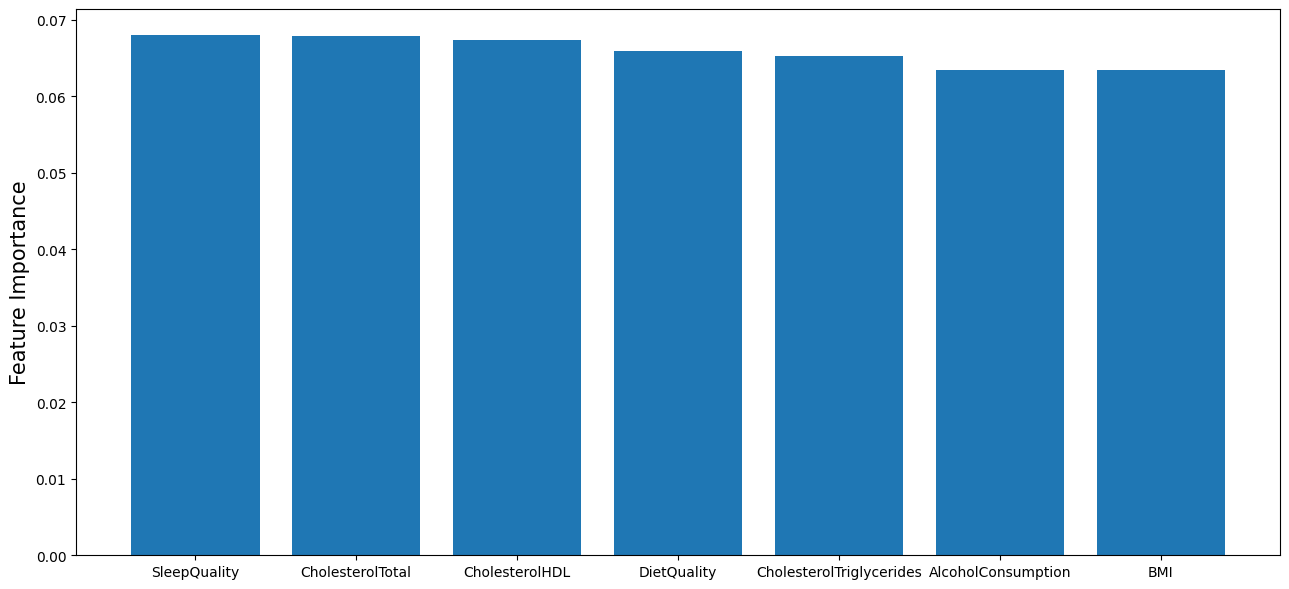

In [64]:
fig, ax = plt.subplots(1, 1, layout = 'tight', figsize = (13, 6))

num_of_shown_feats = 7

ax.bar( [ feat[0] for feat in features_sorted[:num_of_shown_feats] ] , [ feat[1] for feat in features_sorted[:num_of_shown_feats] ], width = 0.8 )

ax.set_ylabel("Feature Importance", fontsize = 15)

The most important features are again measured data like cholesterol and lifestyle features like Sleep Quality, Physical activity and alcohol consumption.

# WHAT NEXT ? 

- perform an exploration of the hyperparameters to identify the optimal ones
- try different classifiers (already tried LogisticRegression, PassiveAggressiveClassifier, AdaBoost. Random Forest is currently the best one).